In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin

In [117]:
df_chunks = pd.read_csv('train.csv', chunksize=10000)
chunk_list = [] 
counter = 0
for chunk in df_chunks:  
    chunk_list.append(chunk)
    if counter == 4:
        break
    counter += 1
    
df = pd.concat(chunk_list)
df = df.dropna()

# Огляд даних

In [118]:
df.shape

(50000, 8)

In [119]:
print(df.info())

print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB
None
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


# Дообробка даних

In [120]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 
    return c * r

In [121]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [122]:
df['distance'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)

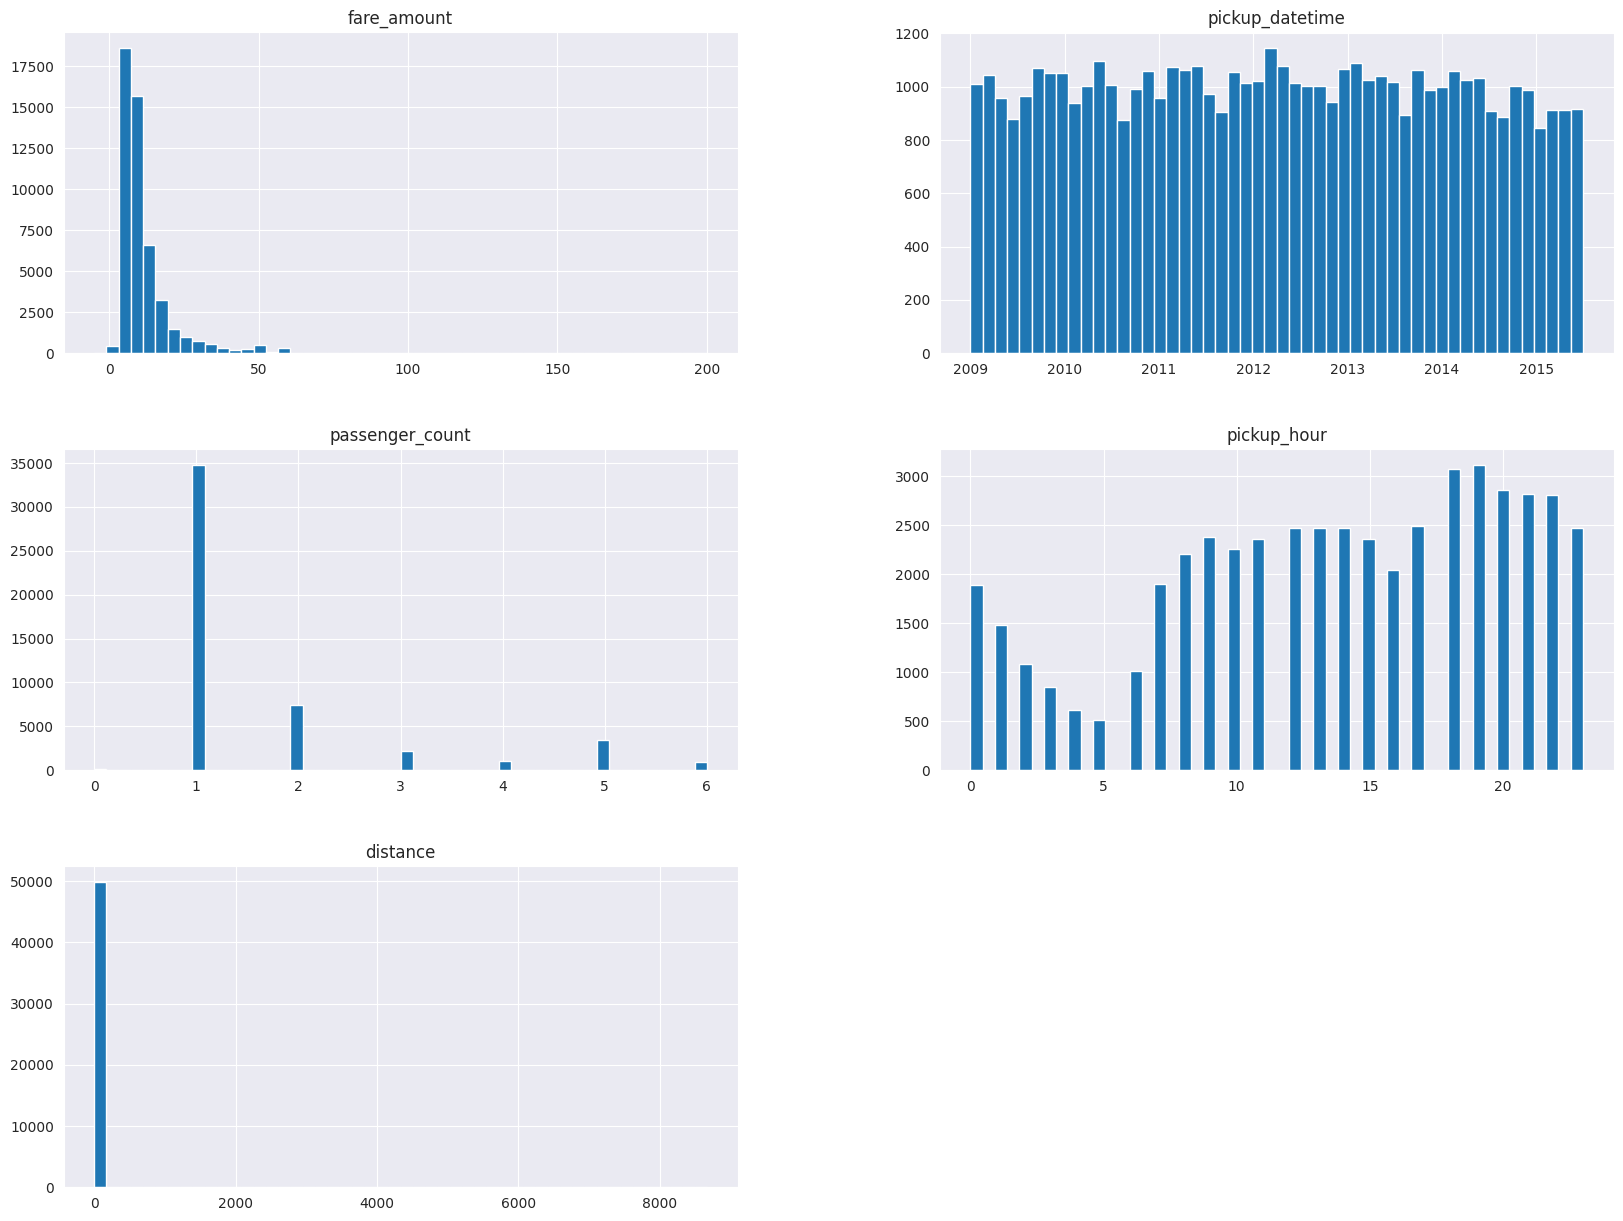

In [123]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

In [124]:
df = df.drop(['pickup_datetime', 'key'], axis=1)
df.drop(df[df['distance']>10].index, axis=0, inplace=True)
df.drop(df[df['distance'] <= 0].index, axis=0, inplace=True)
df.drop(df[df['passenger_count'] == 0].index, axis=0, inplace=True)
df.drop(df[df['fare_amount'] > 20].index, axis=0, inplace=True)
df.drop(df[df['fare_amount'] <= 2.5].index, axis=0, inplace=True)
df.head()

,fare_amount,passenger_count,pickup_hour,distance
0,4.5,1,17,1.030764
1,16.9,1,16,8.450134
2,5.7,2,0,1.389525
3,7.7,1,4,2.799270
4,5.3,1,7,1.999157


Побудова кореляційної матриці

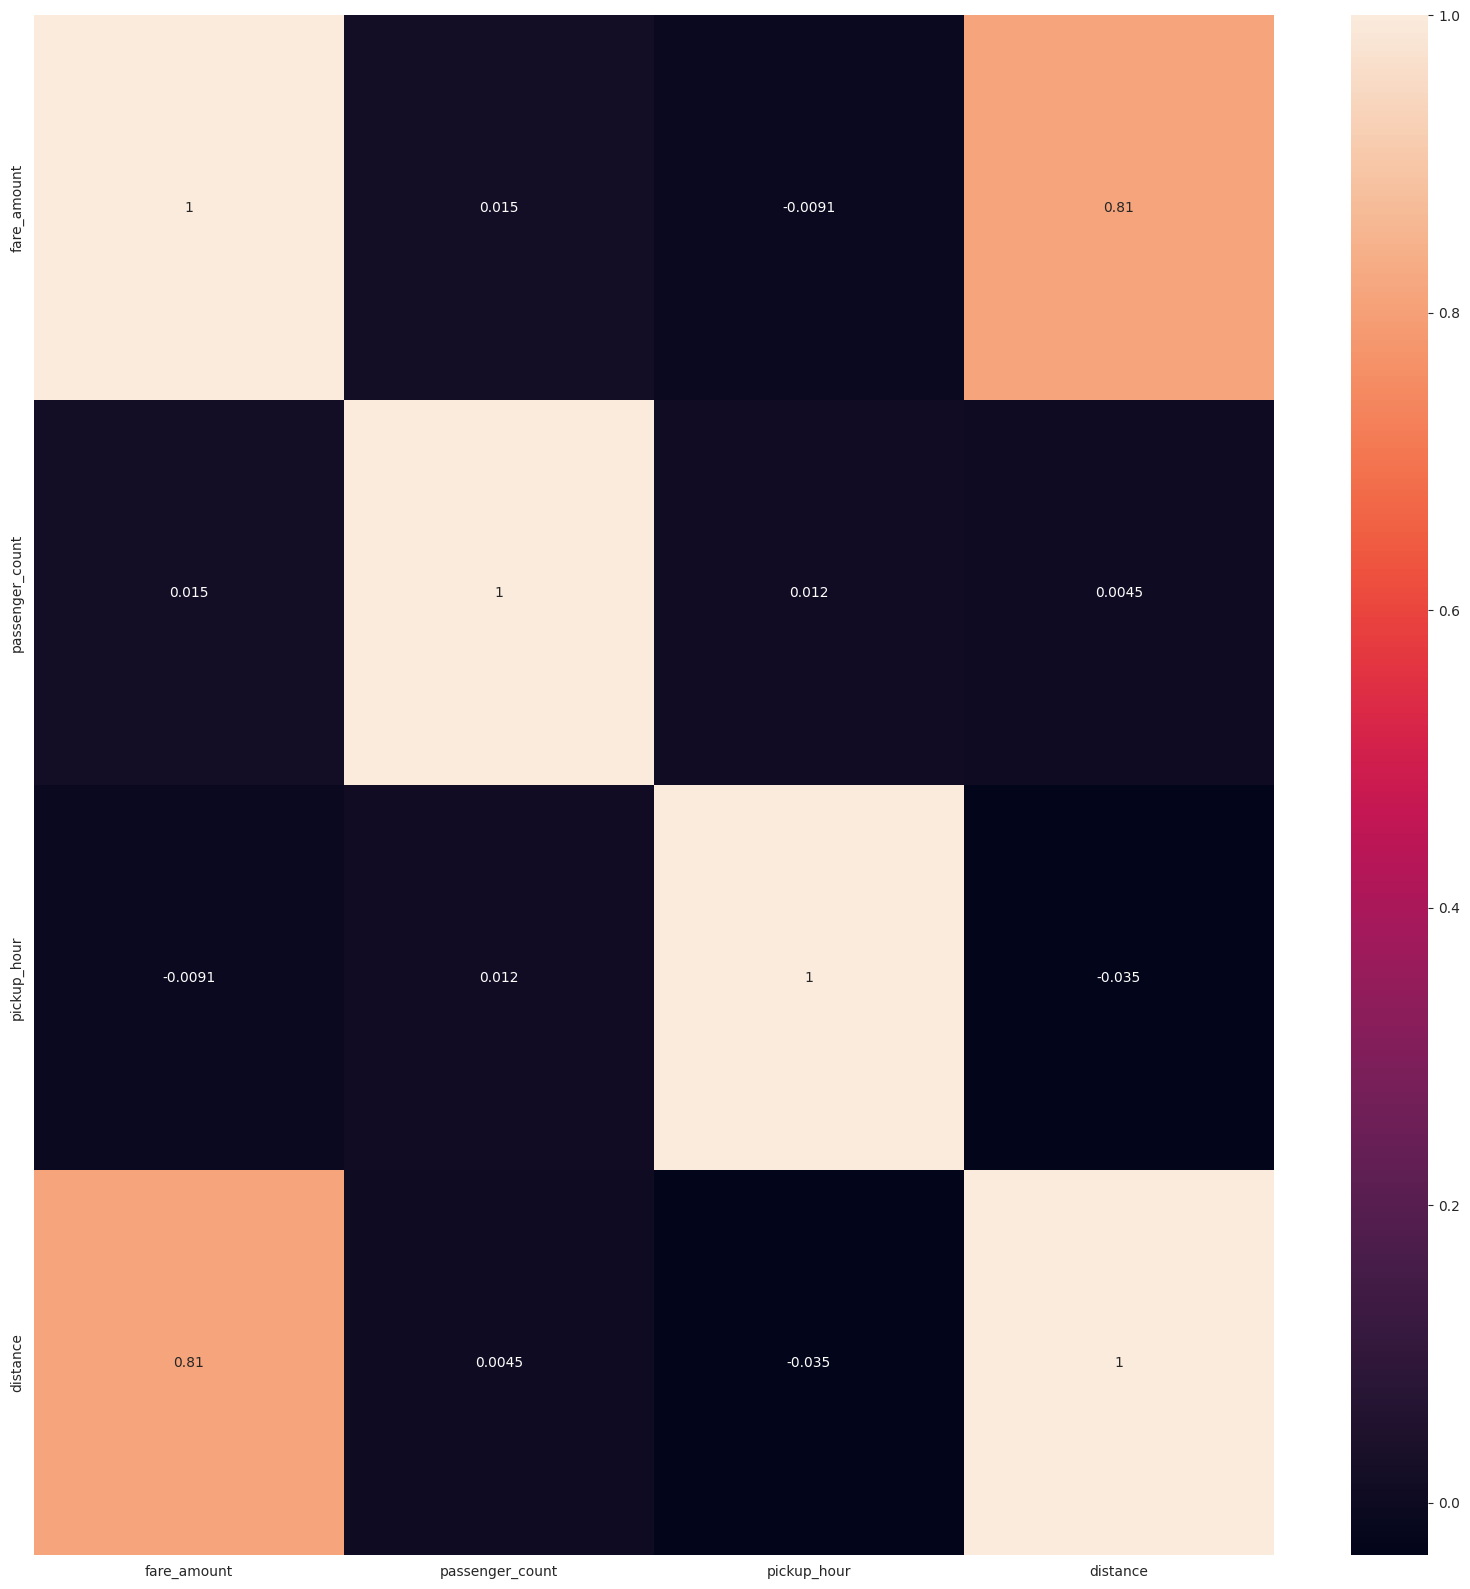

In [125]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

# Співвідношення між характеристиками та цільовим значенням – fake_amount (відсортовано за спаданням)

In [126]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending = False)

fare_amount        1.000000
distance           0.812915
passenger_count    0.015433
pickup_hour       -0.009052
Name: fare_amount, dtype: float64

<Figure size 4000x4000 with 0 Axes>

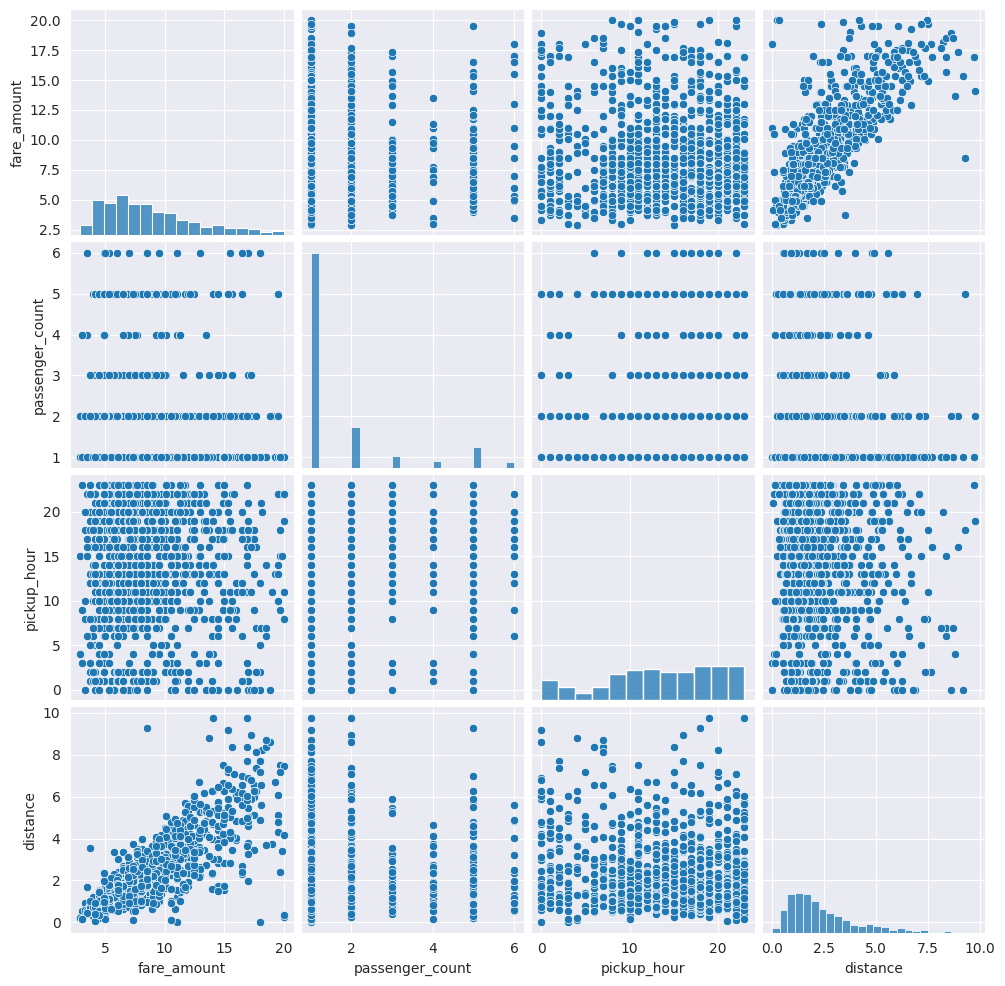

In [127]:
plt.figure(figsize=(40,40))
sns.pairplot(df.sample(1000))
plt.show()

# Побудова стовпчатих діаграм для кожної ознаки

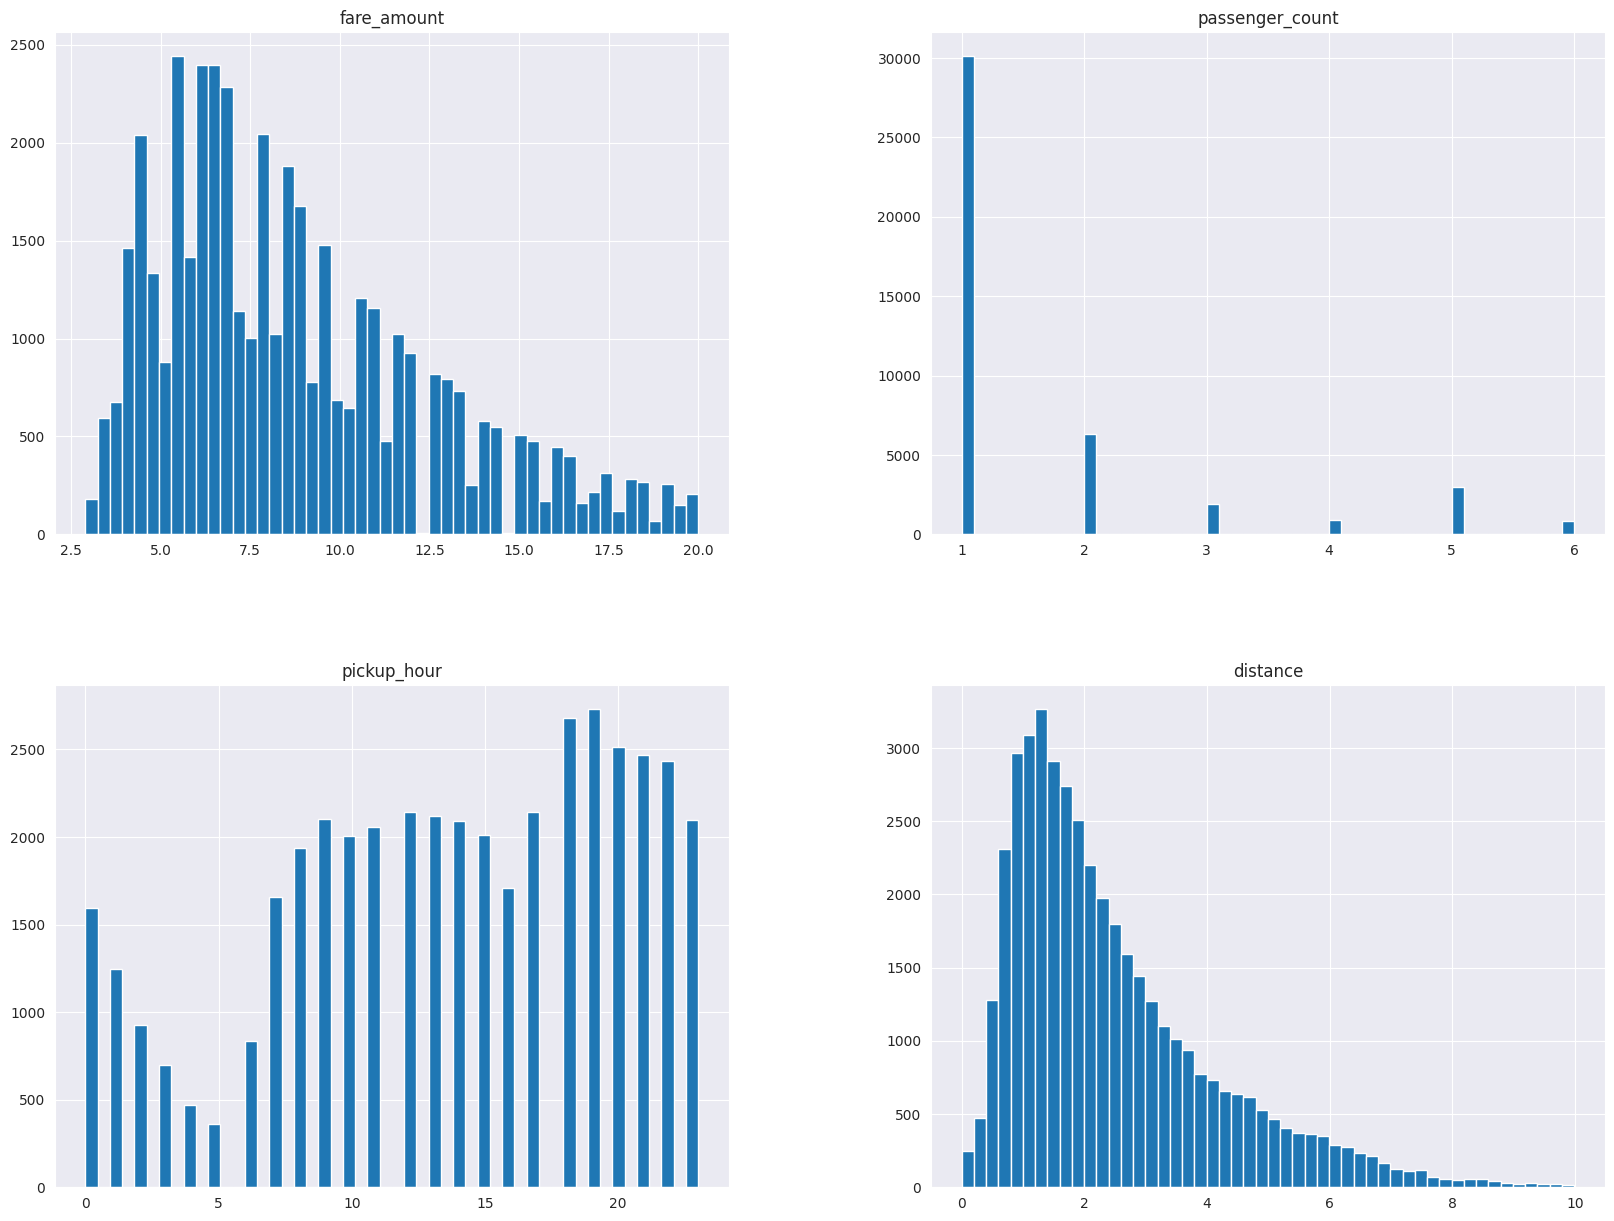

In [128]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

# Розподіл даних

In [129]:
selected_features = ['passenger_count','distance']
X, y = df[selected_features].to_numpy(), df['fare_amount'].to_numpy().reshape(-1,1)
print(X.shape, y.shape)

(43032, 2) (43032, 1)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Custom Linear Regression model

In [131]:
class CustomRegression(RegressorMixin, BaseEstimator):
    def __init__(self, standardize=True, learning_rate=0.01, num_iter=10000, eps=10*(-10), verbose=False):
        self.standardize = standardize
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.eps = eps
        self.verbose = verbose
    
    def normalize(self, X):
        mean = X.mean(axis= 0)
        std = X.std(axis = 0)
        X_new = (X - mean)/std
        return X_new, mean, std

    def prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new

    def hypothesis(self, X, theta):
        h_thetha = np.matmul(X, theta.reshape((-1,1)))
        return h_thetha
    
    def cost_function(self, X, y, theta):
        m = X.shape[0]
        if m == 0:
            return None
        J = (1/(2*m)) * np.dot((self.hypothesis(X, theta) - y).reshape(1, -1)[0], (self.hypothesis(X, theta) - y).reshape(1, -1)[0])
        return J

    def derivative(self, X, y, theta):
        m = X.shape[0]
        d_thetha = (1/m)*np.matmul((self.hypothesis(X, theta)-y).reshape((1, X.shape[0]))[0], X)
        return d_thetha
    
    def gradient_descent(self, X, y, theta, print_J = False):
        m = X.shape[0]
        J_history = []
        iteration_history = []
        J = self.cost_function(X, y, theta)
        if print_J == True:
            print(J)
        J_history.append(J)
        iteration_history.append(0)
        for i in range(self.num_iter):
            delta = self.derivative(X, y, theta)
            theta = theta - self.learning_rate * delta
            J = self.cost_function(X, y, theta)
            if print_J == True:
                print(J)
            J_history.append(J)
            iteration_history.append(i+1)

            #stop condition
            if abs(J_history[-1]-J_history[-2])<self.eps:
                break
        return theta, J_history

    def fit(self, X, y):
        X_new = X.copy()
        if self.standardize:
            X_new, self.mean, self.std = self.normalize(X_new)

        X_prep = self.prepare_X(X_new)
        self.theta = np.zeros(X_prep.shape[1])
        self.theta, self.costs = self.gradient_descent(X_prep, y, self.theta)
        return self


    def predict(self, X):
        X_p = X.copy()
        if self.normalize:
            X_p = (X_p - self.mean)/self.std
        X_p = self.prepare_X(X_p)
        predicted = self.hypothesis(X_p,self.theta);
        return predicted
    
    def coef_(self):
        return self.theta

Перевірка "важливості" функції за допомогою Theta-значень

In [132]:
alpha = 0.01
eps = 10**(-10)
num_iters = 10000

In [133]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))

model_cr = CustomRegression(True, alpha, num_iters, eps)
custom = model_cr.fit(X_train, y_train)
new_theta = custom.theta

feat_imp = []
for i in range(1, len(new_theta)):
   feat_imp.append([new_theta[i], i-1])
feat_imp.sort(reverse=True, key = lambda x:x[0])

print("new theta shape:", custom.theta.shape)
for i in range(len(custom.theta)):
   if i==0:
      print('Bias: {}; '.format(i, custom.theta[i]))
   else:
      print('{}: {}; '.format(selected_features[feat_imp[i-1][1]], feat_imp[i-1][0]))

X_train: (34425, 2)
y_train: (34425, 1)
new theta shape: (3,)
Bias: 0; 
distance: 3.095649875895729; 
passenger_count: 0.049973566618121634; 


In [134]:
model_cr_prediction = custom.predict(X_test)

In [135]:
print('Mean absolute error:', metrics.mean_absolute_error(y_test, model_cr_prediction))
print('M squarred error:', metrics.mean_squared_error(y_test, model_cr_prediction))
print('Root mean squarred error:', np.sqrt(metrics.mean_squared_error(y_test, model_cr_prediction)))
print('R^2 metric:', np.sqrt(metrics.r2_score(y_test, model_cr_prediction)))

Mean absolute error: 1.6275109207331049
M squarred error: 5.0508343187169835
Root mean squarred error: 2.2474061312359597
R^2 metric: 0.8106044656375982


# Перевірка Grid Search

In [136]:
CustomRegressor = CustomRegression()

params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_iter': [1000, 2000, 5000, 10000],
    'eps': [10**(-5), 10**(-8), 10**(-10)]
}

grid_search_custom = GridSearchCV(CustomRegressor, params, cv=10, scoring='r2')
grid_search_custom.fit(X_train, y_train)

y_pred_grid_custom = grid_search_custom.predict(X_test)

best_params = grid_search_custom.best_params_
best_score_grid_custom = grid_search_custom.best_score_

print("Best parameters:", best_params)
print("Best score on train data:", best_score_grid_custom)
print("Score on test data:", r2_score(y_test, y_pred_grid_custom))

Best parameters: {'eps': 1e-10, 'learning_rate': 0.01, 'num_iter': 2000}
Best score on train data: 0.6619479655653511
Score on test data: 0.6570795997116161


# Перевірка Random Search

In [137]:
CustomRegressorR = CustomRegression()

paramsR = {
    'learning_rate': [0.001, 0.01, 0.1, 0.05],
    'num_iter': [1000, 2000, 5000, 10000],
    'eps': [10**(-5), 10**(-8), 10**(-10)]
}

random_search_custom = RandomizedSearchCV(CustomRegressorR, paramsR, n_iter=10, cv=5, scoring='r2', random_state=42)
random_search_custom.fit(X_train, y_train)

y_pred_random_custom = random_search_custom.predict(X_test)

best_params = random_search_custom.best_params_
best_score_random_custom = random_search_custom.best_score_

print("Best parameters:", best_params)
print("Best score on train data:", best_score_random_custom)
print("Score on test data:", r2_score(y_test, y_pred_random_custom))

Best parameters: {'num_iter': 1000, 'learning_rate': 0.1, 'eps': 1e-10}
Best score on train data: 0.6620125163210157
Score on test data: 0.657079946096337


# SKlearn Linear Regression model

In [138]:
lin_reg = LinearRegression(fit_intercept=True).fit(X_train, y_train);

In [139]:
test_X = X_test
test_y = y_test
test_predicted = lin_reg.predict(test_X)


In [140]:
print('Mean absolute error:', metrics.mean_absolute_error(y_test, test_predicted))
print('Mean squarred error:', metrics.mean_squared_error(y_test, test_predicted))
print('Root mean squarred error:', np.sqrt(metrics.mean_squared_error(y_test, test_predicted)))
print('R^2 metric:', np.sqrt(metrics.r2_score(y_test, test_predicted)))

Mean absolute error: 1.6275240019772121
Mean squarred error: 5.050827301543089
Root mean squarred error: 2.2474045700636744
R^2 metric: 0.8106047595063254


In [141]:
print('Bias : {}'.format(lin_reg.intercept_[0]))
feat_imp = []
for i in range(len(selected_features)):
    feat_imp.append([lin_reg.coef_[0][i], i])
feat_imp.sort(reverse=True, key=lambda x:x[0])
for i in range(len(selected_features)):
    print('{} : {}'.format(selected_features[feat_imp[i][1]], feat_imp[i][0]))

Bias : 4.142950953748071
distance : 1.857332076242958
passenger_count : 0.03875664141683812
